## Mahyar Mohammadi-610398166-HW2 
## Memetic Algorithm for N-Queens Problem

### First let's import some librarys

In [4]:
import numpy as np
import pandas as pd
import matplotlib as plt
import random
from math import sqrt

### Fitnnes function

In [76]:
def fitFunc(chromosome):
    res=0
    for i in range(size):
        q1 = chromosome[i]
        for j in range(1,size-i):
            q2 = chromosome[i+j]
            if(abs(q2-q1)==j):res+=1
    return -1*res

### select first society


In [77]:
def getSociety():
    chromosomes = [np.random.permutation(range(size)) for _ in range(sp)]
    fitnesses = [fitFunc(chromosome) for chromosome in chromosomes]
    society = pd.DataFrame({'chromosomes':chromosomes,'fitnesses':fitnesses})
    society = society.sort_values(by='fitnesses').reset_index(drop=True)
    return society


### Define 3 Selection functions

In [78]:
#select choromosoms that have more fitnesses score than the input quantile
def truncation_selection(society):
    return society.tail(int(pc*len(society)/100))

#select choromosoms with probablity based on their ranks 
def proportional_selection(society):
    size = int(pc*len(society)/100)
    soc = society.copy()
    tot = sum(range(len(soc)))
    probs = [i/tot for i in range(len(soc))]
    selected = np.random.choice(list(range(len(soc))),size,p=probs,replace=False)

    selected = list(selected)+list(range(len(soc)))[int(0.09*len(soc)):]
    selected = selected[len(selected):len(selected)-size-1:-1]

    return soc.loc[selected,]

#select 10,20,30,40 percent of each 25% bucket of parents
def part_selection(society):
    size = int(pc*len(society)/100)
    pers = [10,20,30,40]
    mask = np.array([])
    for i in range(4):
        bucket = range(int(i*0.25*len(society)),int((i+1)*0.25*len(society)))
        res = np.random.choice(bucket,int(pers[i]*size/100),replace=False)
        mask = np.concatenate((mask,res ), axis=0)
    mask = np.concatenate((mask[:-1],np.array([len(society)-1]) ), axis=0)
    return society.loc[mask,:].sort_index()
        

### here we define Crossover function

In [237]:
def generate_children(parents):
    #Order Recombination
    def orderRec(couple):
        dad,mom = couple
        child = [-1]*len(dad)

        a,b = np.random.choice(range(len(dad)),2,replace=True)
        start = min(a,b)
        end = max(a,b)
        dadInherit = dad[start:end]
        child[start:end]=dadInherit
        child_set = set(child)
        i=end
        j=end
        if(start==end):return mom
        while(i!=start):
            while(mom[j] in child_set):j = j+1 if j+1!=len(mom) else 0
            child_set.add(mom[j])
            child[i] = mom[j]
            i+=1
            if(i==len(dad)):i=0
        if(np.random.choice([True,False],p=[locProb/100,1-locProb/100])):
            ret = bestLocal(child)
            return ret
        else: 
            ret = (child,fitFunc(child))
            return ret
        
    def bestLocal(chorom):
        temp = tuple(zip(np.random.randint(0,len(chorom),adjCount),
            np.random.randint(0,len(chorom),adjCount)))
        bestChorom = chorom
        bestFit = fitFunc(chorom)
        for key in temp:
            i,j = min(key),max(key)
            newChorom = chorom.copy()
            newChorom[i],newChorom[j] = newChorom[j],newChorom[i]
            newChoromFit = fitFunc(newChorom)
            if(newChoromFit>bestFit):
                bestChorom = newChorom
                bestFit = newChoromFit
        return (bestChorom,bestFit)
        
    #first set couples
    def getCouples(parents):
        shuffle = np.random.choice(parents.chromosomes,len(parents),replace=False)
        a = shuffle[:len(shuffle)//2]
        b = shuffle[len(shuffle)//2:]

        return np.column_stack((a,b))
    
    #Mutation
    def mutation(children):
        #Scramble Mutation
        def mutate(child):
            i,j = np.random.choice(list(range(len(child))),2,replace=False)
            if(i>j): i,j = j,i     
            child[i:j]=np.random.choice(child[i:j],j-i,replace=False)
            return child
            
        #Scramble Reverse Mutation
        def mutate2(child):
            i,j = np.random.choice(list(range(len(child))),2,replace=False)
            if(i>j): i,j = j,i
            child[i:j] = child[j:i:-1]
            return
        
        muted = tuple()
        mutPer = len(children)*mutRate//100
        for i in range(mutPer):
            newChild = mutate(children[i][0])
            muted+=((newChild,fitFunc(newChild)),)
            
        return muted+children[mutPer:]

    count = sp*Prep//100
    #now apply crossover function on each couple and create children until we get the number of children we want
    children=tuple()

    while(len(children)<count):
        coups = getCouples(parents)
        newChildren = tuple(map(orderRec,coups))
        newChildrenEdtied = []
        for child in newChildren:
            if(len(child)==2):
                newChildrenEdtied.append(child)
        children=children+tuple(newChildrenEdtied)

    try:
        children=mutation(children)
    except:
        pass
    #print(len(children))
    #print(children)
    res = [child[0] for child in children]
    fitnesses = [child[1] for child in children]
    
    
    return pd.DataFrame({'chromosomes':res,'fitnesses':fitnesses}).head(count)

In [243]:
def newGeneration(society,children):
    res = pd.concat([children,society.loc[range(len(children),len(society))]],axis=0)
    return res.sort_values(by='fitnesses').reset_index().drop(['index'],axis=1)


In [252]:
def societyStat(society):
    stat = society.fitnesses
    return -1*stat.mean(),-1*stat.max()

In [391]:
def chessMaker(arr):
    n = len(arr)
    row1 = [0 if(i%2==0) else 1 for i in range(n)]
    row2 = [1 if(i%2==0) else 0 for i in range(n)]
    mat = [row1.copy() if(i%2==0) else row2.copy() for i in range(n)]

    for i in range(n):
        mat[i][arr[i]]=2
        
    plt.pyplot.figure(figsize=(n,n))
    plt.pyplot.imshow(mat,cmap='gray')
    return 

In [362]:
def runAlgorithm(printRate=5,society=None):
    global lastSociety
    if(type(society)==type(None)):
        society = getSociety()
    socMean,socMin = societyStat(society)
    print(f"the first generation-> Mean:{socMean},Min:{socMin}")
    means=[socMean]
    mins=[socMin]
    repetead = 0
    lastMin = -1
    i=0
    while(socMin):
        parents = part_selection(society)
        childs = generate_children(parents)
        newSociety = newGeneration(society,childs)
        socMean,socMin = societyStat(newSociety)
        means.append(socMean)
        mins.append(socMin)
        if((i+2)%printRate==0):print(f"the {i+2}th generation-> Mean:{socMean},Min:{socMin}")
        i+=1
        society = newSociety
        lastSociety = newSociety

    print(f"the {i+2}th(last) generation-> Mean:{socMean},Min:{socMin}")
    df = pd.DataFrame({'Mean':means,'min':mins})
    df.plot()
    res = society[society.fitnesses==society.fitnesses.max()]['chromosomes'].values[0]
    print("result:",res)
    chessMaker(res)
    return 

the first generation-> Mean:6.05,Min:3
the 5th(last) generation-> Mean:2.0,Min:0
result: [6, 4, 9, 1, 3, 7, 2, 8, 5, 0]


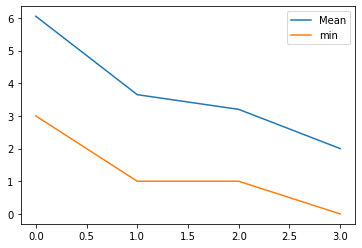

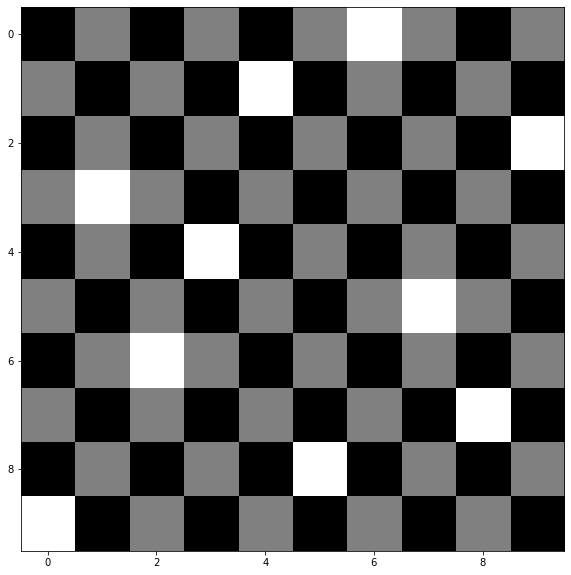

In [392]:
#chessborad size
size = 10

#society population
sp = 20

#parents percent
pc = 60

#the percent of previuos generation that replace with children on next generation
Prep = 50

#local search number of adjacent
adjCount = 100

#how many of children get muted
mutRate = 5

#how many of children should replace with best local
locProb = 50
runAlgorithm(20)

ok let's make this harder!

In [376]:
#chessborad size
size = 100

#society population
sp = 20

#parents percent
pc = 60

#the percent of previuos generation that replace with children on next generation
Prep = 50

#local search number of adjacent
adjCount = 100

#how many of children get muted
mutRate = 5

#how many of children should replace with best local
locProb = 50


the first generation-> Mean:65.9,Min:50
the 20th generation-> Mean:35.25,Min:28
the 40th generation-> Mean:24.35,Min:16
the 60th generation-> Mean:18.2,Min:10
the 80th generation-> Mean:13.45,Min:5
the 100th generation-> Mean:8.05,Min:3
the 118th(last) generation-> Mean:0.95,Min:0
result: [24, 92, 29, 58, 25, 84, 50, 7, 66, 26, 63, 47, 76, 52, 56, 23, 32, 54, 79, 60, 19, 33, 93, 72, 70, 30, 27, 89, 35, 83, 17, 69, 8, 90, 28, 48, 71, 5, 3, 65, 62, 64, 44, 95, 0, 77, 86, 21, 39, 82, 1, 96, 40, 73, 49, 59, 20, 9, 11, 22, 53, 38, 81, 46, 42, 80, 97, 51, 4, 6, 99, 14, 45, 98, 16, 85, 57, 43, 13, 88, 78, 67, 74, 94, 55, 34, 15, 41, 10, 36, 75, 61, 18, 31, 2, 91, 68, 87, 37, 12]


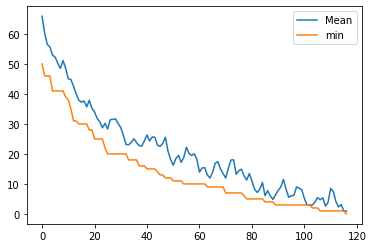

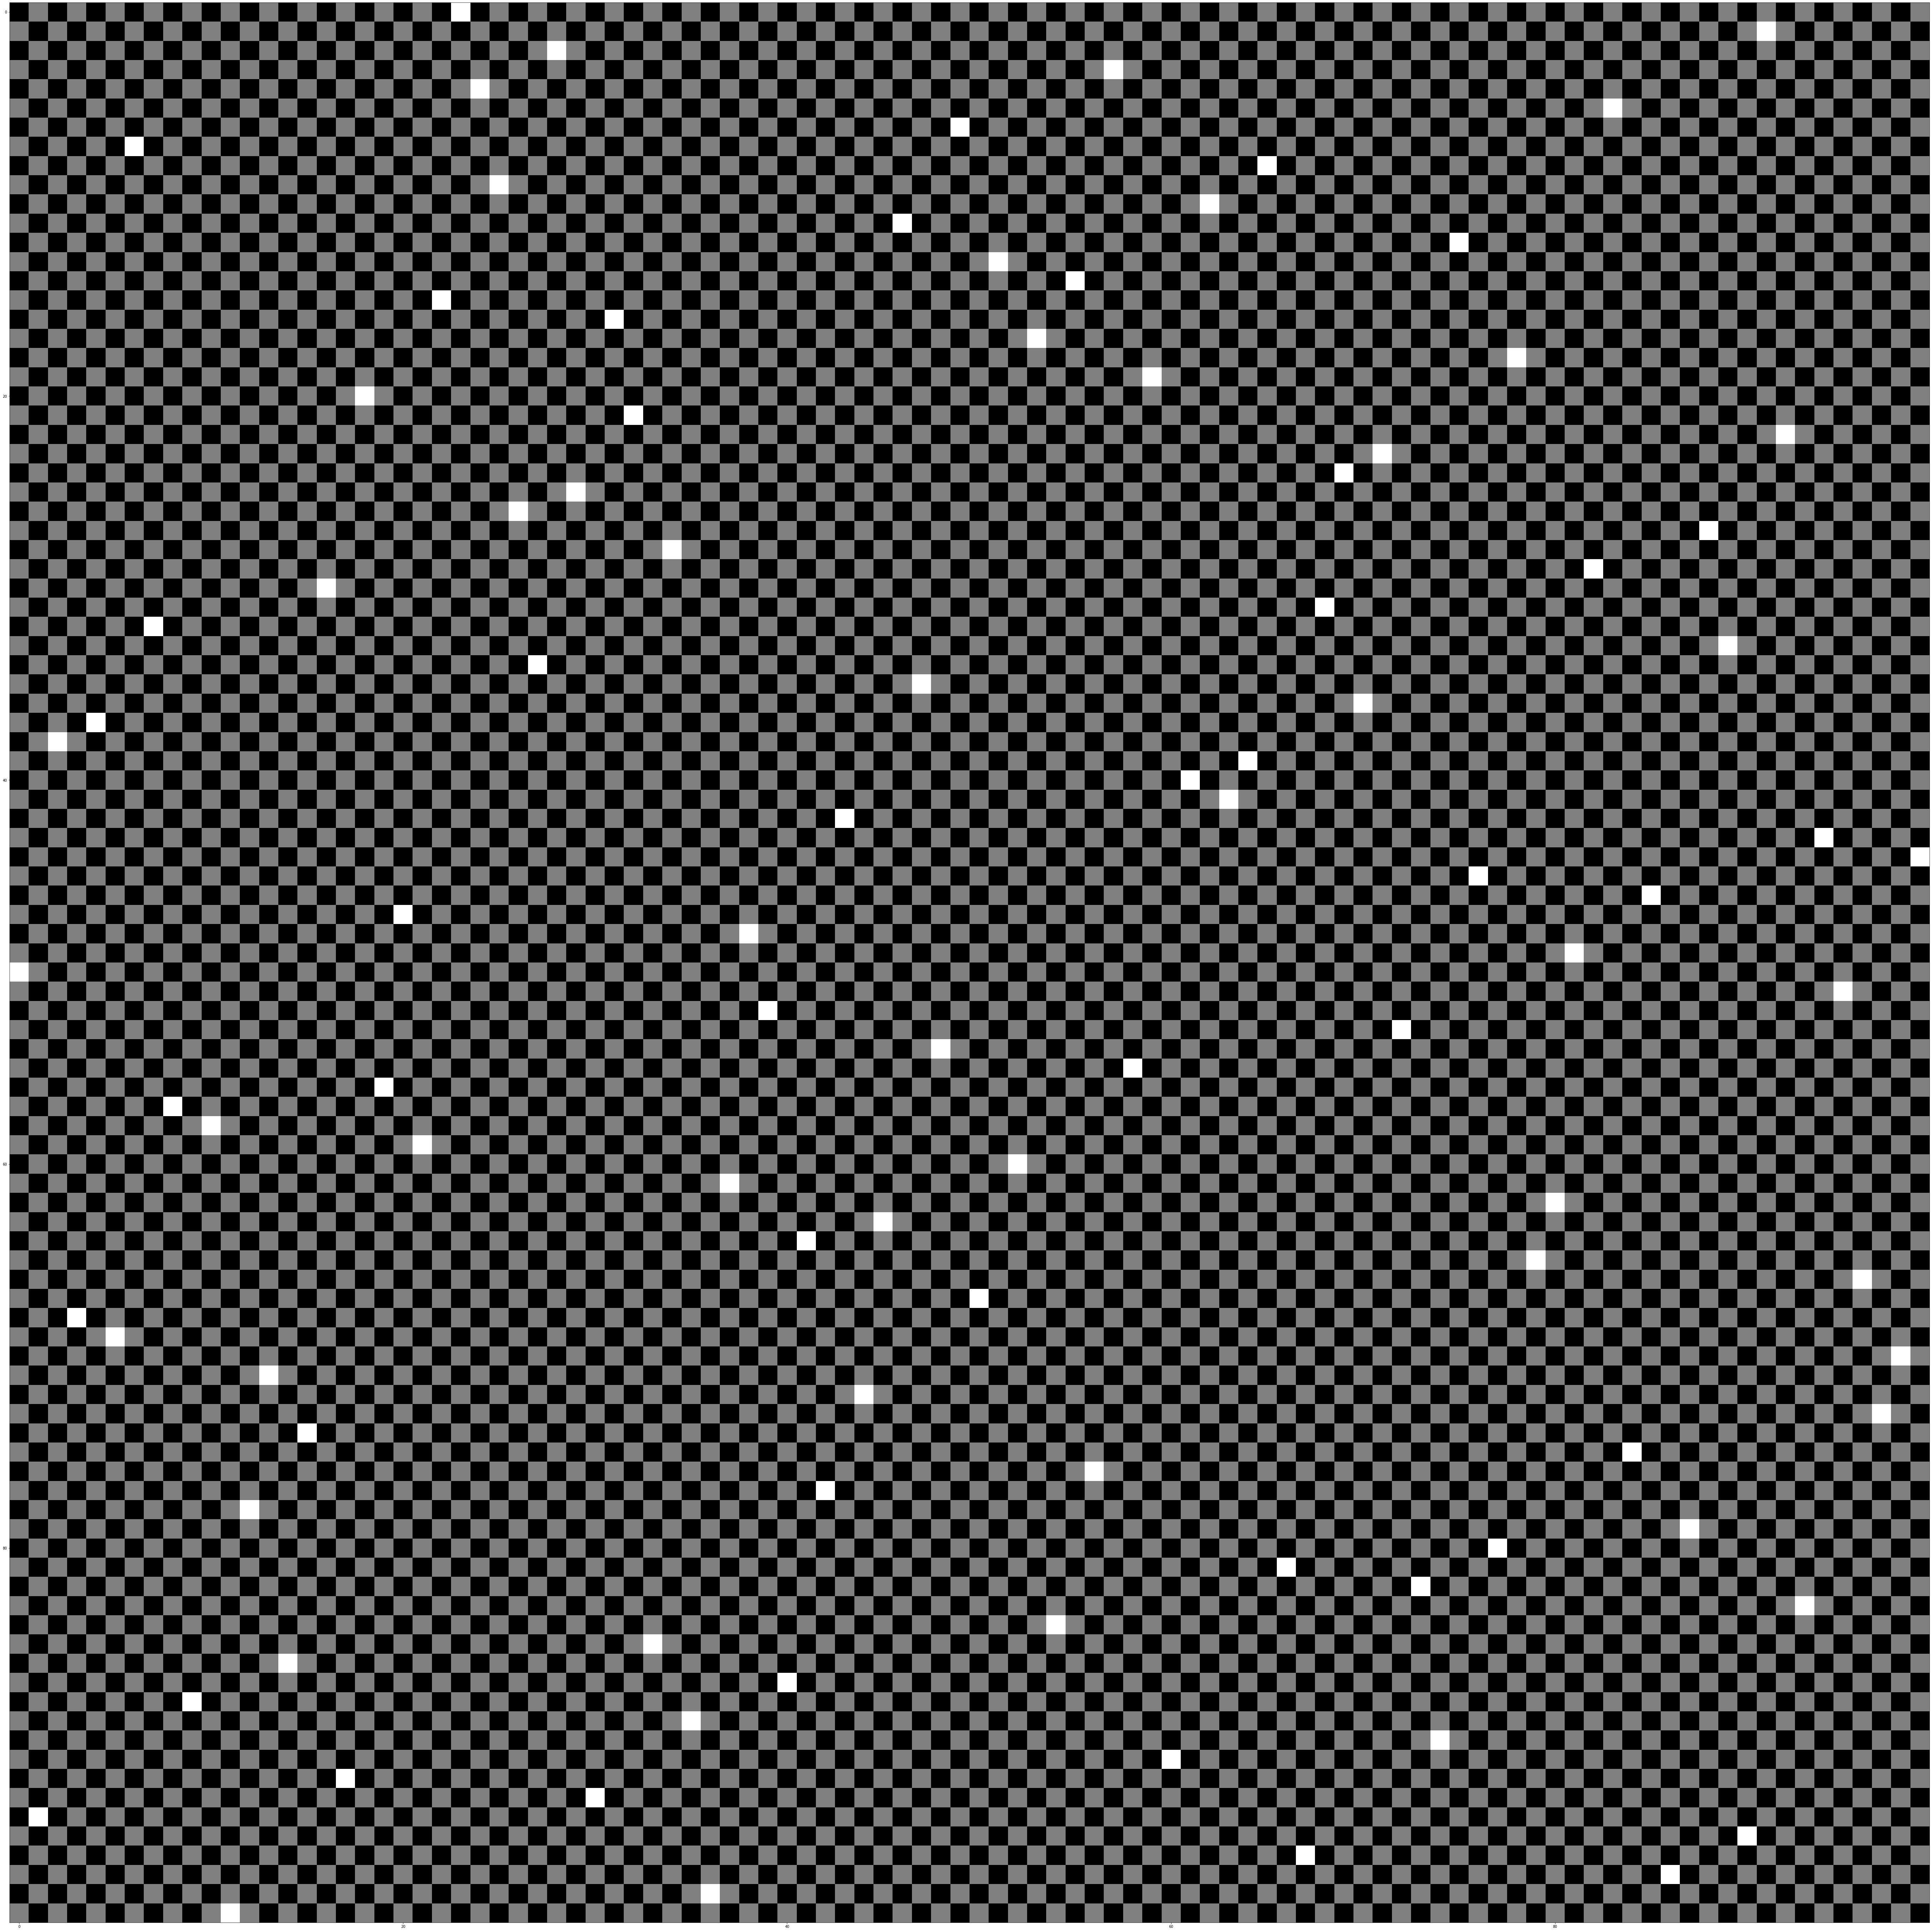

In [377]:
runAlgorithm(20)

i found that less population is faster and also effective in this problem. i find the answer of n=100 with population of sp=100 in 10min but find it with sp=20 in 4min and less generation. so the answers of this problem are very close to each other.

the first generation-> Mean:66.13,Min:49
the 5th generation-> Mean:56.46,Min:42
the 10th generation-> Mean:53.9,Min:39
the 15th generation-> Mean:50.46,Min:37
the 20th generation-> Mean:49.35,Min:34
the 25th generation-> Mean:48.16,Min:34
the 30th generation-> Mean:46.09,Min:34
the 35th generation-> Mean:45.13,Min:33
the 40th generation-> Mean:44.53,Min:29
the 45th generation-> Mean:43.02,Min:29
the 50th generation-> Mean:36.85,Min:25
the 55th generation-> Mean:34.73,Min:23
the 60th generation-> Mean:34.22,Min:20
the 65th generation-> Mean:32.22,Min:18
the 70th generation-> Mean:30.38,Min:17
the 75th generation-> Mean:33.57,Min:17
the 80th generation-> Mean:29.89,Min:16
the 85th generation-> Mean:29.46,Min:16
the 90th generation-> Mean:28.09,Min:14
the 95th generation-> Mean:25.29,Min:12
the 100th generation-> Mean:21.45,Min:7
the 105th generation-> Mean:19.65,Min:7
the 110th generation-> Mean:16.99,Min:5
the 115th generation-> Mean:14.57,Min:3
the 120th generation-> Mean:9.13,Min:2
th

,chromosomes,fitnesses
0,"[18, 61, 31, 62, 10, 92, 57, 44, 87, 37, 21, 7...",-59
1,"[24, 18, 62, 10, 92, 58, 96, 21, 5, 44, 80, 8,...",-42
2,"[18, 62, 10, 92, 57, 61, 44, 87, 37, 21, 76, 2...",-40
3,"[12, 24, 18, 62, 10, 92, 57, 44, 37, 21, 76, 2...",-37
4,"[24, 18, 62, 10, 92, 57, 44, 61, 37, 21, 76, 2...",-34
...,...,...
95,"[12, 24, 18, 62, 10, 92, 57, 44, 87, 37, 21, 7...",-1
96,"[12, 24, 18, 62, 10, 92, 57, 44, 87, 37, 21, 7...",-1
97,"[12, 24, 18, 62, 10, 92, 57, 44, 87, 37, 21, 7...",-1
98,"[12, 24, 18, 62, 10, 92, 57, 44, 87, 37, 21, 7...",-1


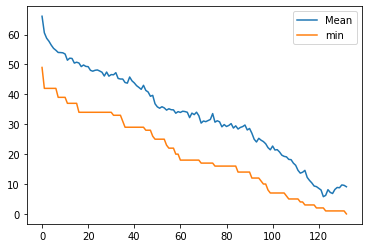

In [272]:
runAlgorithm()

In [353]:
#chessborad size
size = 300

#society population
sp = 20

#parents percent
pc = 60

#the percent of previuos generation that replace with children on next generation
Prep = 40

#local search number of adjacent
adjCount = 100

#how many of children get muted
mutRate = 5

#how many of children should replace with best local
locProb = 20

lastSociety = 0

In [354]:
runAlgorithm(10)

the first generation-> Mean:198.4,Min:182
the 10th generation-> Mean:175.1,Min:155
the 20th generation-> Mean:158.65,Min:143
the 30th generation-> Mean:143.0,Min:129
the 40th generation-> Mean:129.1,Min:122
the 50th generation-> Mean:127.2,Min:114
the 60th generation-> Mean:116.0,Min:104
the 70th generation-> Mean:105.65,Min:96
the 80th generation-> Mean:100.2,Min:88
the 90th generation-> Mean:91.65,Min:81
the 100th generation-> Mean:82.3,Min:74
the 110th generation-> Mean:78.0,Min:72
the 120th generation-> Mean:70.85,Min:67
the 130th generation-> Mean:70.8,Min:62
the 140th generation-> Mean:70.6,Min:59
the 150th generation-> Mean:73.4,Min:57
the 160th generation-> Mean:63.0,Min:55
the 170th generation-> Mean:71.35,Min:52
the 180th generation-> Mean:71.2,Min:51
the 190th generation-> Mean:68.6,Min:47
the 200th generation-> Mean:53.45,Min:46
the 210th generation-> Mean:63.9,Min:42
the 220th generation-> Mean:50.35,Min:42
the 230th generation-> Mean:49.3,Min:37
the 240th generation-> Mea

KeyboardInterrupt: 

convergence happend on 1!!!
so what is wrong? when the population is 20(that is small number) we should increase the mutation rate. since the algorithm gueses get much lower it get stock on local optimum very quickly. so we increase mutrate by 100%.

In [372]:
#chessborad size
size = 300

#society population
sp = 20

#parents percent
pc = 60

#the percent of previuos generation that replace with children on next generation
Prep = 40

#local search number of adjacent
adjCount = 100

#how many of children get muted
mutRate = 10

#how many of children should replace with best local
locProb = 20


the first generation-> Mean:203.1,Min:176
the 25th generation-> Mean:150.5,Min:132
the 50th generation-> Mean:126.85,Min:114
the 75th generation-> Mean:108.75,Min:97
the 100th generation-> Mean:99.6,Min:89
the 125th generation-> Mean:90.1,Min:78
the 150th generation-> Mean:79.9,Min:65
the 175th generation-> Mean:67.35,Min:58
the 200th generation-> Mean:81.45,Min:50
the 225th generation-> Mean:49.55,Min:46
the 250th generation-> Mean:53.65,Min:38
the 275th generation-> Mean:40.35,Min:34
the 300th generation-> Mean:30.75,Min:27
the 325th generation-> Mean:44.15,Min:22
the 350th generation-> Mean:33.45,Min:20
the 375th generation-> Mean:33.75,Min:17
the 400th generation-> Mean:23.2,Min:14
the 425th generation-> Mean:16.75,Min:10
the 450th generation-> Mean:37.15,Min:7
the 475th generation-> Mean:5.3,Min:5
the 500th generation-> Mean:10.7,Min:4
the 525th generation-> Mean:4.85,Min:3
the 550th generation-> Mean:3.3,Min:3
the 575th generation-> Mean:6.1,Min:3
the 600th generation-> Mean:8.8,

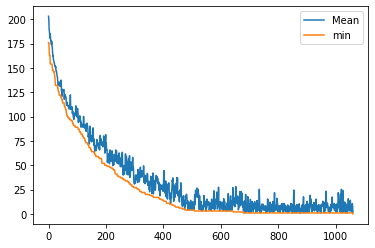

In [373]:
runAlgorithm(25)

So this result happend for n=300

### So what just happend?

choromosoms definition:
since no queens can be at the same row or column, we consider a permutation p, which queen i in row i is on column p[i]. this permutation is our choromosom.

fitness definition:
for every permutation we define fitness the negative number of threats. for example if just 2 queen threat each other the fitness is -1. 

crossover definition:
we simply choose a random range of father choromosom and set them to child. then we fill the rest of child with mother.

local search definition:
we call two choromosoms neighbors if we can convert them to themselves by just swap 2 index of that permutation. for example 1234 and 1243 are adjacent. this type of definition tested many times and selected as the best way to define adjacency.(faster and more efficent
we choose 100 adjacent choromosms of our child and select best of them.

we should control mean and minimum. when mean get so close to minimum of a generation, this means that the standard deviation is low and the genetic diversity of our generation is low. So the convergence happend very quickly on some local result and the algorithm stop searching for better generation.
in this case we can do this things:
1. increase mutation rate
2. increase the percent of choromosoms that choose to be parents not just the better one.
3. decrease the replacement rate and save more choromosoms from previous generation

also we can get better result by decreasing our generation population. 